# Spaxel-by-Spaxel fitting

The best thing we can do is not just get the integrated spectra of the whole galaxy or individual clumps, but we can also look at each individual spaxel and measure those properties. This procedure should include these steps:

1. You go through each spaxel in the cube - or in a mask

2. Extract the spectrum for that spaxel

3. Fit a model to that 1D spectrum (e.g. emission lines, continuum, absorption)

4. Store the fitted parameters (e.g., flux, velocity, width) in a 2D map

# Performing spaxel-by-spaxel masking

We start like before with importing the right libraries, and load the data

## Loading data and background subtraction

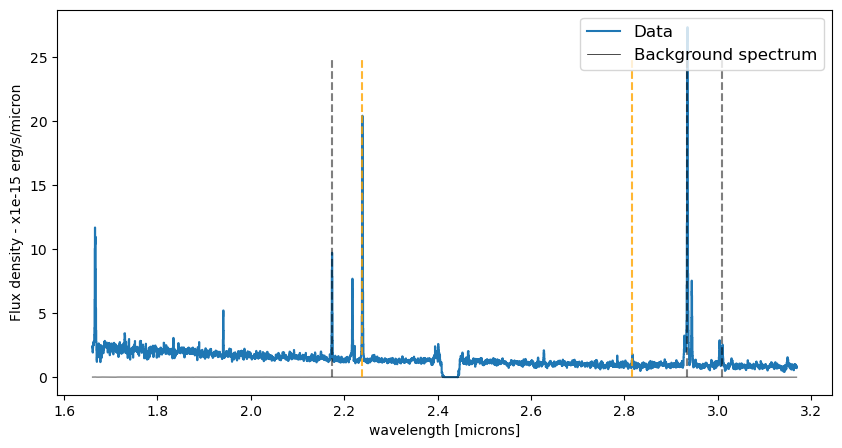

In [40]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy.optimize import curve_fit

import emcee
import corner 

from os.path import exists
nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23



PATH='/Users/jansen/My Drive/Astro/'


path = '/Users/jansen/JADES/GA_NIFS/IFS_data_v1/' 
file_name = '5001-GS-3.47-S_jw1216_o005_ff_px0.05_drizzle_ODfde98_3_VSC_MRC_MSA_m2ff_CTX1068.pmap_v1.8.2_g235h-f170lp_cgs_s3d.fits' # Full path to the file

Full_path = path + file_name

with pyfits.open(Full_path, memmap=False) as hdulist:

    Flux_cube = hdulist['SCI'].data *1e4 * 1e15
    Header = hdulist['SCI'].header

    n_channels = Header['NAXIS3'] # Extract the number pixels in the third axis (wavelength)
    obs_wave = Header['CRVAL3'] + (np.arange(n_channels) - (Header['CRPIX3'] - 1.0))*Header['CDELT3'] # Extract the wavelength grid


z = 3.471

# perform background subtraction
Background_spec = pyfits.getdata('/Users/jansen/work/Torun_school/Background_spec.fits')
Background_spec *= 1e4 * 1e15  # dont forget to normalize it like you did with the flux cube

from scipy.signal import medfilt
# apply median filter to the background spectrum
Background_smoothed = medfilt(np.array(Background_spec, dtype=float), 51)

# Subtract the background from the flux cube
Flux_cube -= Background_smoothed[:, np.newaxis, np.newaxis]



# You can verify everything went well just like last time:

def sp_circ_ap(cenx,ceny,rad,Flux_cube):

    nwl = len(Flux_cube[:,0,0])
    nx = len(Flux_cube[0,0,:])
    ny = len(Flux_cube[0,:,0])
    # creates array with one spectrum per row
    intermarray = np.full((nwl,nx*ny), np.nan)
    # fills it with nans
    
    nloop = 0
    # loop on data
    for x in range(nx) :
        for y in range(ny) :  
            distance = np.sqrt((x-cenx)**2+(y-ceny)**2)
            if distance < rad :
                intermarray[:,int(nloop)] = Flux_cube[:,int(y),int(x)]
                nloop += 1
               
    # average
    outspec = np.nansum(intermarray,axis=1)
    return outspec

D1_spec = sp_circ_ap(44,47,5,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid', label='Data')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.plot(obs_wave, Background_spec, color='k', lw=0.5, label='Background spectrum')


ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.6300*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

#ax.set_xlim(2.15,2.25)

ax.legend(loc='upper right', fontsize=12)
plt.show()



## Preparation for Spaxel-by-spaxel fitting:

We need to do certain amount of preparation of our code to be neatly folded into the for loops we will be using. For example we need to create a function that will fit the individual spaxel spectrum. Its input should be the spaxel spectrum and the output should be the results of the fitting. 

Then we should have a seperate function which takes the results of the fitting and estimate the SNR, flux, extract FWHM, and the relative velocity of the spaxle spectrum. 

## Now the spaxel-by-spaxel fitting

First you should create 2D array that will store all of the variables you will estimate: SNR, flux, FWHM etc. 

In [41]:
SNR_map = np.full( Flux_cube.shape[1:], np.nan) # creates a 2D array of the shape of X,Y of the IFU cube with nan values
# Create the rest:

now in order to fit the entire cube you can just iterate over the full cube:

However, this is very inefficent since a lot of the spaxel are empty, we know it based on the info we got from the QFitsView. We can try to something smart like create a Halpha map and try to only fit spaxel with SNR>3 mask. But that gets fiddly based on your detection algorithm (just like in broad band images), I like to create a mask in QFitsView and save the mask. 

![Screenshot 2025-07-13 at 15.27.08.png](<attachment:Screenshot 2025-07-13 at 15.27.08.png>)

you can then load the mask like an image and only fit the spectrum if mask == 1 in the spaxel you are trying to fit. 
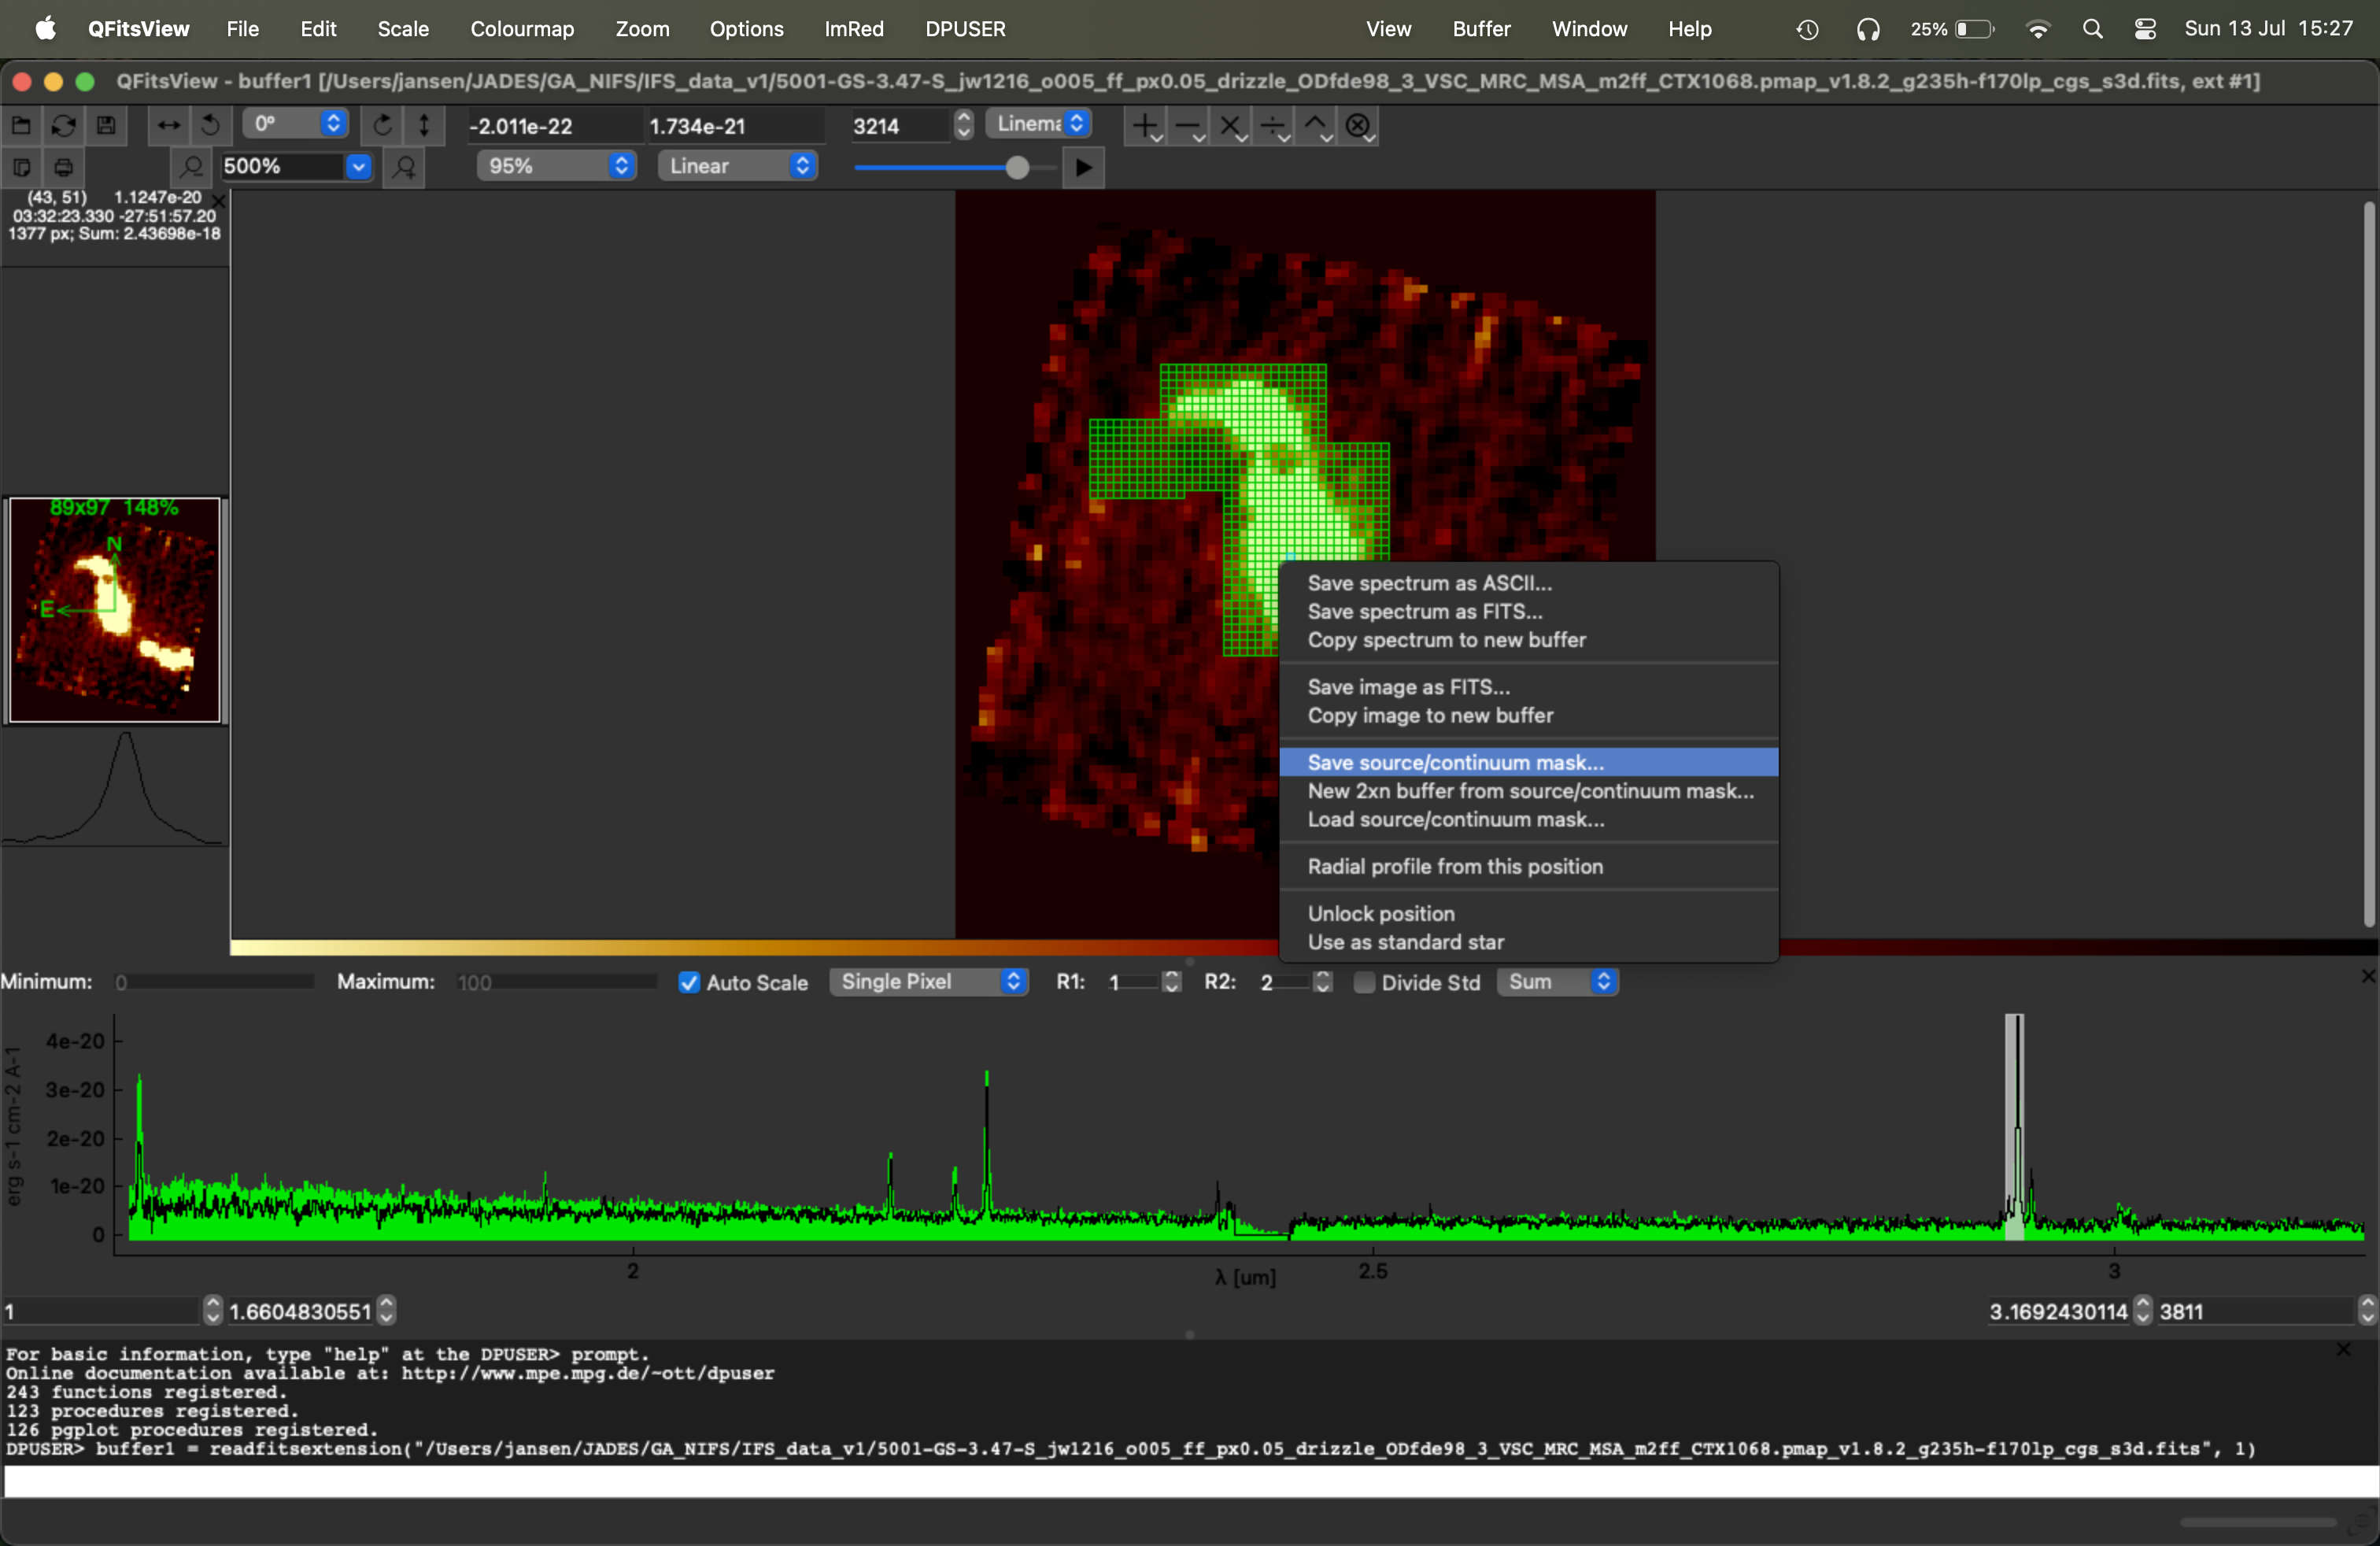

In [42]:
# Defining the model for fitting emission lines around Halpha including of course Halpha itself. 
# Setting up a single Gaussian - will be used later 
def gauss(x, k, mu,FWHM):
    sig = FWHM/2.35482/3e5*mu
    expo= -((x-mu)**2)/(2*sig*sig) 
    y= k* e**expo
    return y

# Setting up the Halpha model:
# First we calculate the observed frame wavelengths of the lines
# Then we calculate the individfual components - Halpha, [NII] and [SII]
# Finally we add all of them together
def OIII_Hbeta(x, z, cont,cont_grad,  OIII_peak, Hbeta_peak, Nar_fwhm):
    OIIIr_wv = 5008.24*(1+z)/1e4    
    OIIIb_wv = 4960.*(1+z)/1e4
    Hbeta_wv = 4862.6*(1+z)/1e4
    
    OIII_nar = gauss(x, OIII_peak, OIIIr_wv, Nar_fwhm) + gauss(x, OIII_peak/2.99, OIIIb_wv, Nar_fwhm)

    Hbeta_nar = gauss(x, Hbeta_peak, Hbeta_wv, Nar_fwhm)
    continuum = cont+x*cont_grad

    return continuum+ OIII_nar + Hbeta_nar

# Extract Emission line parameters from the fit

def flux_calc(index, rest_wave,popt):
                
    wv0 = rest_wave*(1+popt[0])/1e4
    fwhm = popt[-1]

    a = 1./(2*(fwhm/3e5*wv0/2.35482)**2)
    Flux = popt[index]*np.sqrt(np.pi/a) *1e-15 # Remember when I said that we normalize the spectrum earlier? That where the 1e-15 factor comes in

    return Flux


def SNR_calc(index, rest_wave, popt, error, obs_wave):
    wv0 = rest_wave*(1+popt[0])/1e4
    fwhm = popt[-1]
    fwhm_wv = fwhm/3e5*wv0
    eml_model = gauss(obs_wave,popt[index], wv0 , fwhm) 


    use = np.where( ((wv0-fwhm_wv)<obs_wave) & (obs_wave< (wv0+fwhm_wv)))[0]
    flux_sel = eml_model[use]

    n = len(use)
    SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[0])
    return SNR

def Fitting_OIII_Hbeta(obs_wave, D1_spec, z):

    flux = D1_spec.data[np.invert(D1_spec.mask)]
    wave = obs_wave[np.invert(D1_spec.mask)]
        
    fit_loc = np.where((wave>(5008-300)*(1+z)/1e4)&(wave<(5008+300)*(1+z)/1e4))[0]
        
    sel=  np.where(((wave<(5008+20)*(1+z)/1e4))& (wave>(5008-20)*(1+z)/1e4))[0]
    flux_zoom = flux[sel]
    wave_zoom = wave[sel]
        
    peak_loc = np.ma.argmax(flux_zoom)
    peak = np.ma.max(flux_zoom)

    import astropy.stats as stats
    sigma = stats.sigma_clipped_stats(flux[fit_loc], sigma=3, maxiters=5)[2]
    # sigma is the standard deviation of the flux in the selected region
    error = np.ones_like(flux) * sigma

    from scipy.optimize import curve_fit

    init_c = [z,np.median(flux),0.01, peak, peak/4, 200. ]

    dz = 500/3e5*(1+z)

    popt, pcov = curve_fit(OIII_Hbeta, wave[fit_loc], flux[fit_loc], sigma= error[fit_loc], p0= init_c,\
                           bounds=([z-dz,0.,-np.inf, 0., 0., 100.], [z+dz, np.inf, np.inf, np.inf, np.inf, 500.]))

    #Flux_OIII = flux_calc(3, 5008.24, popt)
    #Flux_Hbeta = flux_calc(4, 4862., popt)

    return popt, pcov 

In [43]:
mask_object = pyfits.getdata('/Users/jansen/work/Torun_school/Source_mask.fits')

Popt_cube = np.full((6, Flux_cube.shape[1], Flux_cube.shape[2]), np.nan)  # Initialize the output array for fitting parameters

import tqdm 
for i in tqdm.tqdm(range(Flux_cube.shape[1])):
    for j in range(Flux_cube.shape[2]):

        if mask_object[i, j] == 1:  # Only fit spaxels where the mask is 1
            Spaxel_spec = np.ma.masked_invalid(Flux_cube[:, i, j])

            try:
                popt, pcov = Fitting_OIII_Hbeta(obs_wave, Spaxel_spec, z)
                Popt_cube[:, i, j] = popt
            except:
                Popt_cube[:, i, j] = np.nan


100%|██████████| 97/97 [00:09<00:00, 10.40it/s] 


In [50]:
OIII_flux = np.full(Flux_cube.shape[1:], np.nan)  # Initialize the output array for OIII fluxes
Hbeta_flux = np.full(Flux_cube.shape[1:], np.nan)  # Initialize the output array for Hbeta fluxes

vel_map = np.full(Flux_cube.shape[1:], np.nan)  # Initialize the output array for velocity maps
FWHM_map = np.full(Flux_cube.shape[1:], np.nan)  # Initialize the output array for FWHM maps

for i in tqdm.tqdm(range(Flux_cube.shape[1])):
    for j in range(Flux_cube.shape[2]):
        Spaxel_spec = np.ma.masked_invalid(Flux_cube[:, i, j])

        fit_loc = np.where((obs_wave>(5008-300)*(1+z)/1e4)&(obs_wave<(5008+300)*(1+z)/1e4))[0]
        
    
        import astropy.stats as stats
        sigma = stats.sigma_clipped_stats(Spaxel_spec[fit_loc], sigma=3, maxiters=5)[2]
        # sigma is the standard deviation of the flux in the selected region
        error = np.ones_like(obs_wave) * sigma

        SNR_OIII = SNR_calc(3, 5008.24, Popt_cube[:, i, j],error , obs_wave)
        SNR_Hbeta = SNR_calc(4, 4862.6, Popt_cube[:, i, j],error , obs_wave)

        if SNR_OIII>5:
            OIII_flux[i,j] = flux_calc(3, 5008.24, Popt_cube[:, i, j])

            vel_map[i,j] = (Popt_cube[0, i, j]-z)/(1+z) * 3e5  # Convert redshift to velocity in km/s
            FWHM_map[i,j] = Popt_cube[-1, i, j]
        if SNR_Hbeta>5:
            Hbeta_flux[i,j] = flux_calc(4, 4862.6, Popt_cube[:, i, j])


  0%|          | 0/97 [00:00<?, ?it/s]/var/folders/9_/yz12dmd91q15jc1ckhvbh93m0000gn/T/ipykernel_95022/1243730280.py:49: RuntimeWarning: invalid value encountered in scalar divide
  SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[0])
/var/folders/9_/yz12dmd91q15jc1ckhvbh93m0000gn/T/ipykernel_95022/1243730280.py:49: RuntimeWarning: invalid value encountered in scalar divide
  SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[0])
/var/folders/9_/yz12dmd91q15jc1ckhvbh93m0000gn/T/ipykernel_95022/1243730280.py:49: RuntimeWarning: invalid value encountered in scalar divide
  SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[0])
/var/folders/9_/yz12dmd91q15jc1ckhvbh93m0000gn/T/ipykernel_95022/1243730280.py:49: RuntimeWarning: invalid value encountered in scalar divide
  SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[0])
/var/folders/9_/yz12dmd91q15jc1ckhvbh93m0000gn/T/ipykernel_95022/1243730280.py:49: RuntimeWarning: invalid value encountered in scalar divide
  SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[0

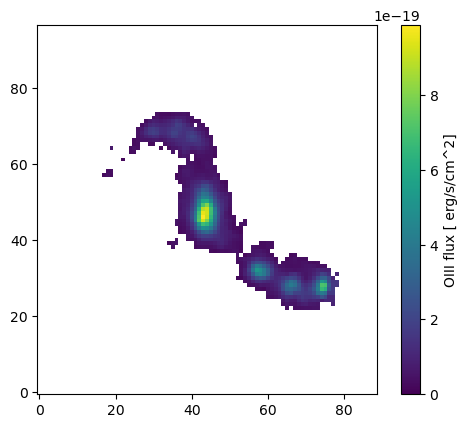

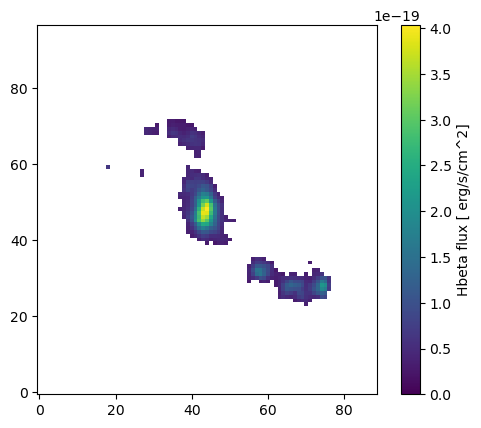

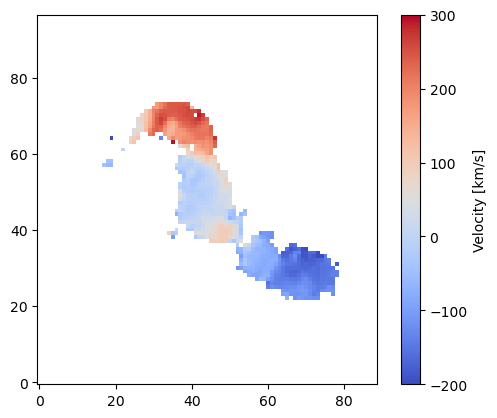

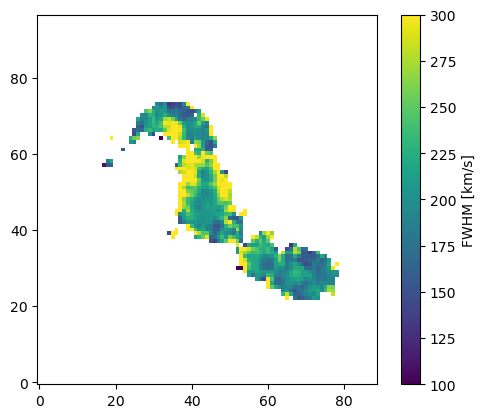

In [51]:

plt.figure()

plt.imshow(OIII_flux, origin='lower', cmap='viridis', vmin=0)
plt.colorbar(label='OIII flux [ erg/s/cm^2]')

plt.figure()

plt.imshow(Hbeta_flux, origin='lower', cmap='viridis', vmin=0)
plt.colorbar(label='Hbeta flux [ erg/s/cm^2]')


plt.figure()

plt.imshow(vel_map, origin='lower', cmap='coolwarm', vmin=-200, vmax=300)
plt.colorbar(label='Velocity [km/s]')

plt.figure()

plt.imshow(FWHM_map, origin='lower', cmap='viridis', vmin=100,vmax=300)
plt.colorbar(label='FWHM [km/s]')

plt.show()

# Save the maps!

np.savetxt(FULL_PATH, SNR_map)

In [46]:
# Plot the maps

# Now the complicated stuff. 

Now the real fun begins. We have hopefully managed to fit a single component to the emission line. Now you should fit a simple model with one Gaussian per emission line and a two component model with two Gaussians per emission lines. Compare the BIC of the two fits and then estimate the properties from the best fit. 